In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.stats import chi2_contingency
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments





C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Overview

This dataset consists of 600 multilingual customer support tickets, each containing a variety of features that provide both textual information and metadata. The dataset is primarily used for classifying support tickets into their appropriate `queue` (department or category) based on the text in the `subject` and `body`.

### Key Features:
- **subject**: The subject line of the support ticket, typically a brief summary of the issue.
- **body**: The main content or detailed description of the support request.
- **queue**: The department or category to which the ticket is assigned. This is the target variable for classification.
- **language**: The language of the support ticket, as the dataset contains entries in multiple languages (e.g., English, Spanish, German).

In addition to these key features, the dataset includes several other columns:
- **id**: A unique identifier for each support ticket.
- **type**: The type of request (e.g., "Incident", "Request").
- **priority**: The priority level assigned to the ticket.
- **business_type**: The business sector the ticket is related to.
- **tags**: Additional tags related to the ticket, which may contain missing values.

I will start by loading and inspecting the dataset to understand its structure and identify any missing values.


In [ ]:
# Load the dataset
data = pd.read_csv('helpdesk_customer_tickets.csv')
print(data.head())


In [4]:
print(data.info()) 
print(data.describe(include='all'))  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             600 non-null    int64  
 1   subject        599 non-null    object 
 2   body           600 non-null    object 
 3   answer         600 non-null    object 
 4   type           600 non-null    object 
 5   queue          600 non-null    object 
 6   priority       600 non-null    object 
 7   language       600 non-null    object 
 8   business_type  600 non-null    object 
 9   tag_1          600 non-null    object 
 10  tag_2          600 non-null    object 
 11  tag_3          600 non-null    object 
 12  tag_4          600 non-null    object 
 13  tag_5          432 non-null    object 
 14  tag_6          173 non-null    object 
 15  tag_7          56 non-null     object 
 16  tag_8          9 non-null      object 
 17  tag_9          0 non-null      float64
dtypes: float64

<Axes: ylabel='count'>

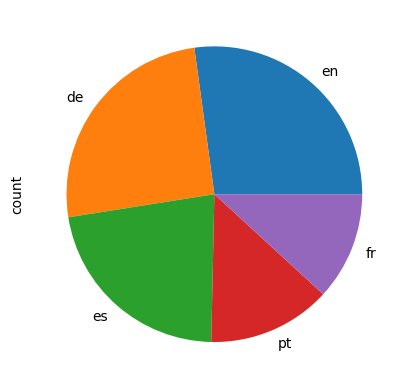

In [5]:
data['language'].value_counts().plot(kind='pie')

<Axes: xlabel='priority'>

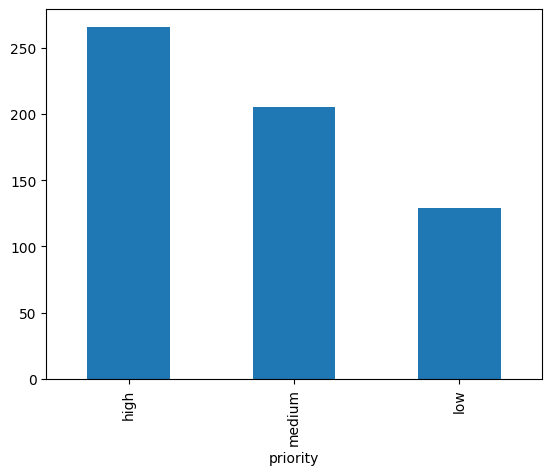

In [6]:
data['priority'].value_counts().plot(kind='bar')

<Axes: ylabel='queue'>

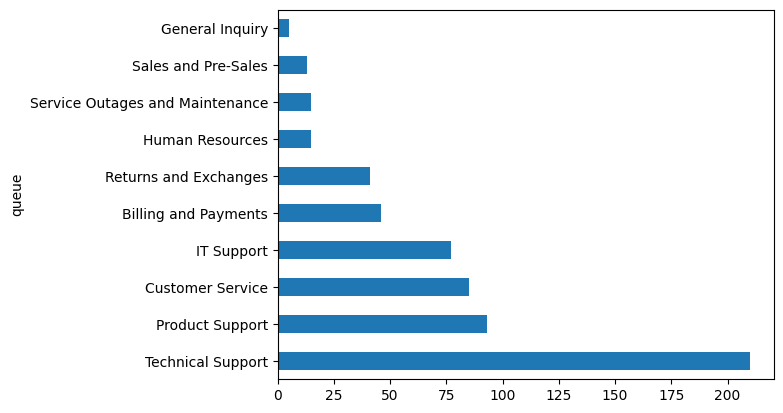

In [7]:
data['queue'].value_counts().plot(kind='barh')

In [16]:
len(data)

600

array([[<Axes: title={'center': 'body_length'}>,
        <Axes: title={'center': 'subject_length'}>]], dtype=object)

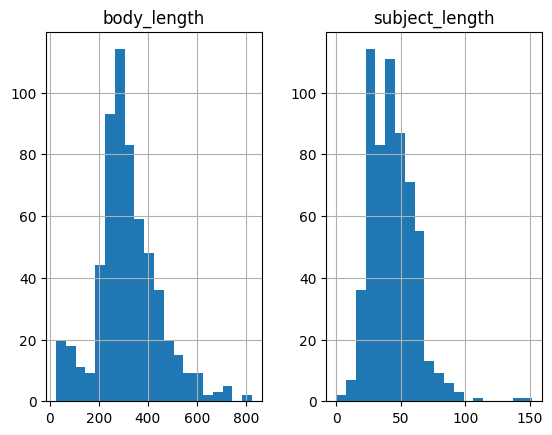

In [8]:
data['body_length'] = data['body'].apply(len)

# Fill NaN values with an empty string
data['subject'] = data['subject'].fillna('')
data['subject_length'] = data['subject'].apply(len)
data[['body_length', 'subject_length']].hist(bins=20)


In [9]:
from collections import Counter
words = ' '.join(data['body']).split()
common_words = Counter(words).most_common(20)
print(common_words)


[('de', 915), ('<name>', 429), ('a', 263), ('para', 204), ('to', 186), ('<tel_num>', 166), ('I', 164), ('Sie', 154), ('la', 152), ('the', 146), ('ich', 131), ('Dear', 122), ('this', 119), ('Online', 117), ('Thank', 116), ('in', 114), ('en', 114), ('Tech', 113), ('zu', 112), ('un', 109)]


<Axes: xlabel='language'>

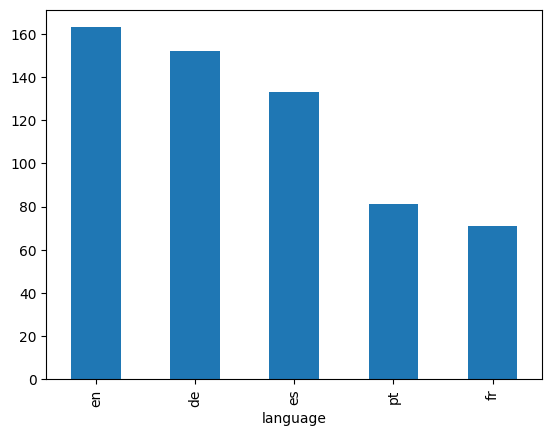

In [10]:
data['language'].value_counts().plot(kind='bar')


<Axes: xlabel='queue'>

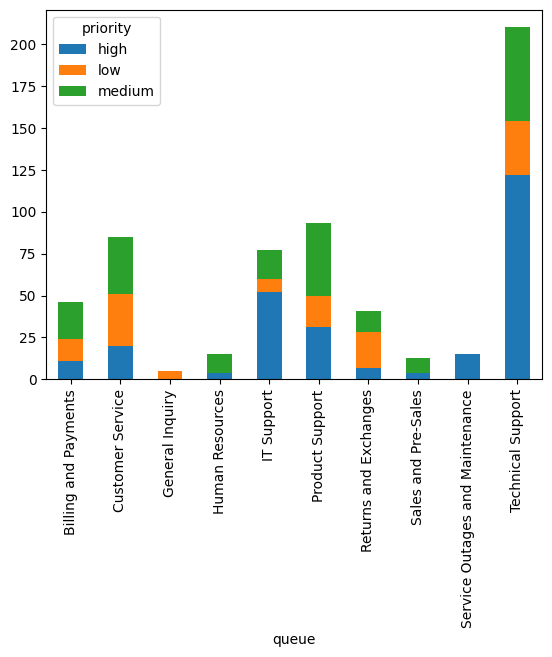

In [11]:
pd.crosstab(data['queue'], data['priority']).plot(kind='bar', stacked=True)


<Axes: xlabel='type'>

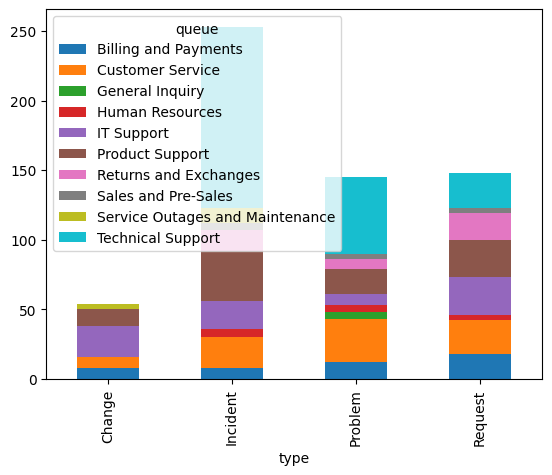

In [12]:

pd.crosstab(data['type'], data['queue']).plot(kind='bar', stacked=True)

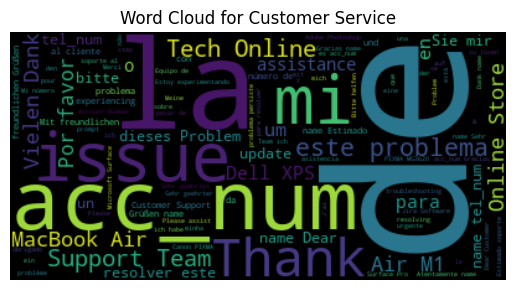

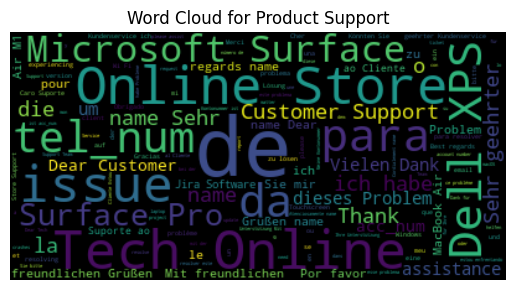

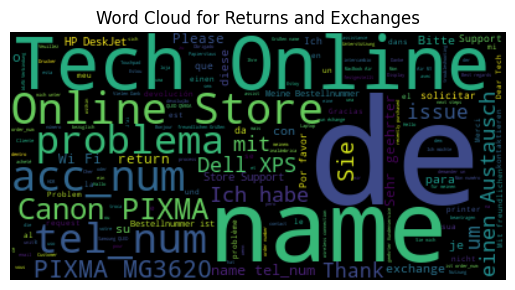

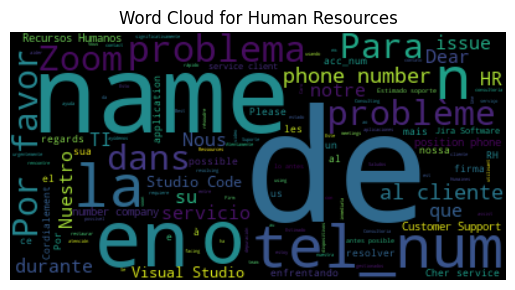

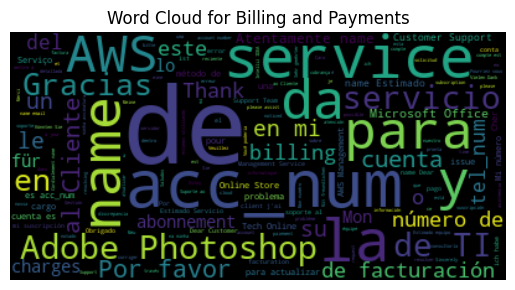

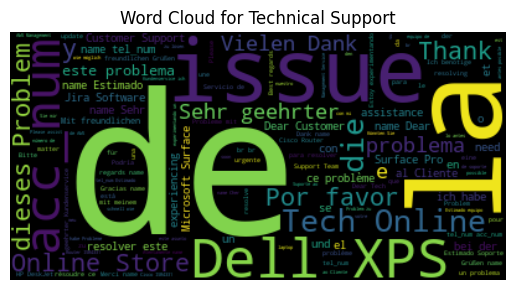

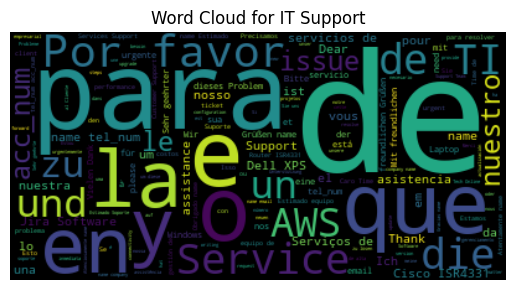

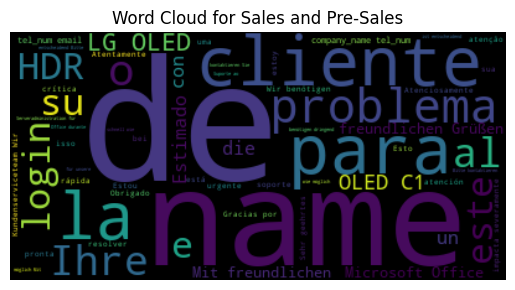

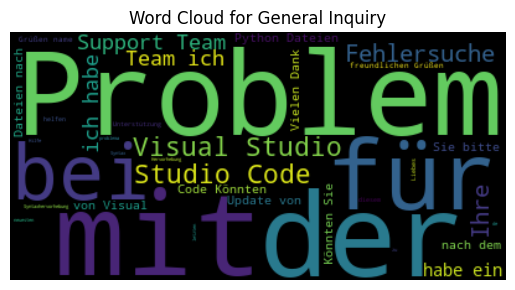

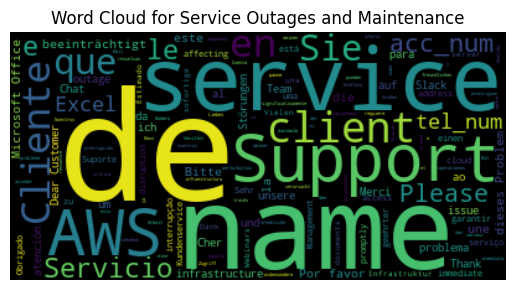

In [13]:
from wordcloud import WordCloud
for queue in data['queue'].unique():
    text = ' '.join(data[data['queue'] == queue]['body'])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {queue}')
    plt.axis("off")
    plt.show()


<Axes: xlabel='queue'>

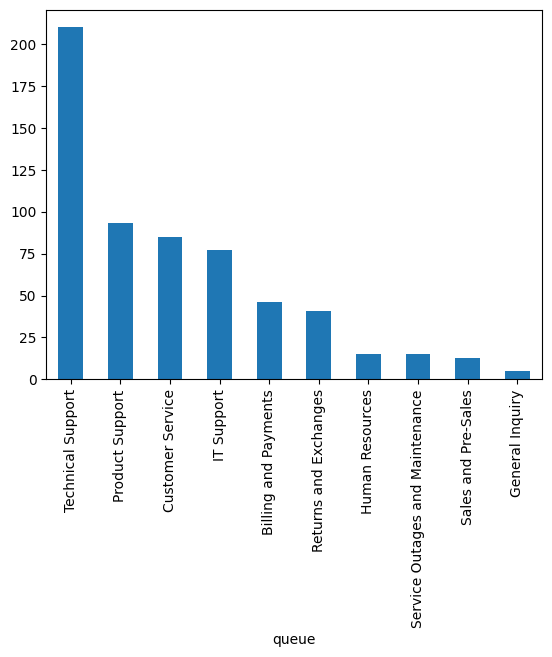

In [14]:
data['queue'].value_counts().plot(kind='bar')


In [15]:
# Check for missing values
print(data.isnull().sum())

# Check the distribution of queues (departments)
print(data['queue'].value_counts())




id                  0
subject             0
body                0
answer              0
type                0
queue               0
priority            0
language            0
business_type       0
tag_1               0
tag_2               0
tag_3               0
tag_4               0
tag_5             168
tag_6             427
tag_7             544
tag_8             591
tag_9             600
body_length         0
subject_length      0
dtype: int64
queue
Technical Support                  210
Product Support                     93
Customer Service                    85
IT Support                          77
Billing and Payments                46
Returns and Exchanges               41
Human Resources                     15
Service Outages and Maintenance     15
Sales and Pre-Sales                 13
General Inquiry                      5
Name: count, dtype: int64


In [17]:
# Define a function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

# Apply Cramér's V to check association between 'priority' and 'queue'
cramer_v_priority = cramers_v(data['priority'], data['queue'])
print(f"Cramér's V between 'priority' and 'queue': {cramer_v_priority}")

# Repeat for other features
cramer_v_type = cramers_v(data['type'], data['queue'])
print(f"Cramér's V between 'type' and 'queue': {cramer_v_type}")


Cramér's V between 'priority' and 'queue': 0.348332298902228
Cramér's V between 'type' and 'queue': 0.31289719890680995


## Exploratory Data Analysis (EDA): Categorical Feature Correlation

In this step, I explored the relationships between some of the categorical features and the target variable (`queue`) to assess their potential predictive value. Since the features like `priority` and `type` are categorical, I used **Cramér's V** to measure the strength of association between these features and the target variable.

**Cramér's V** is a suitable metric for determining the correlation between two categorical variables. It provides a value between 0 and 1, where:
- **0** indicates no association.
- **1** indicates a strong association.

I applied Cramér's V to the following features:
- **Priority**: This represents the importance or urgency of the ticket.
- **Type**: This represents the type of request, such as "Incident" or "Request."

### Results:
- Cramér's V between `priority` and `queue`: **0.348**
- Cramér's V between `type` and `queue`: **0.313**

These values indicate a moderate association between these features and the target variable. Although the correlations are not very strong, they suggest that `priority` and `type` could still provide some useful signals to the model and will be included in further analysis.


FEATURE SELECTION AND PROCESSING

In [ ]:
# Handle missing values
data['subject'] = data['subject'].fillna('')
data['body'] = data['body'].fillna('')

# Combine subject and body with a space or delimiter for clarity
data['combined_text'] = data['subject'].str.strip() + ' ' + data['body'].str.strip()

# Check the result
print(data[['subject', 'body', 'combined_text']].head(10))


## Feature Selection for Model Development

After performing Exploratory Data Analysis (EDA) and assessing the available features, I decided to focus the model development on the **`subject`** and **`body`** columns. These two columns contain the core textual data of the support tickets, which are likely to have the most significant impact on predicting the correct `queue` (target variable). 

### Reason for Combining `Subject` and `Body`:
- The `subject` typically provides a brief summary of the issue, while the `body` contains a more detailed description. By combining both columns, the model can leverage both the high-level and detailed information in the ticket.
- Combining these two fields ensures that no important context is missed, as some tickets may have key information only in the `subject` or only in the `body`.

### Why Only These Two Features Were Selected:
1. **Textual Relevance**: The `subject` and `body` provide direct, unstructured data that likely describes the issue or request, making them the most relevant for predicting the appropriate `queue`. In contrast, other features such as `priority` or `type` offer additional metadata but do not describe the nature of the issue as fully.
  
2. **Moderate Correlation of Other Features**: As shown in the Cramér’s V analysis, features like `priority` and `type` have only moderate correlation with the `queue`. While these features could provide some useful metadata, their predictive power is likely to be weaker than the actual content of the ticket.

By focusing on the textual content of the support tickets, I aim to capture the most informative features for classification.


In [31]:
from transformers import DistilBertTokenizer
# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

data['tokenized'] = data['combined_text'].apply(lambda x: tokenizer(x, padding='max_length', truncation=True, max_length=128))

## Preprocessing: Tokenization

For preprocessing the textual data, I used the **DistilBertTokenizer** from Hugging Face’s Transformers library. This tokenizer was selected for the following reasons:

### Why DistilBERT?
- **Multilingual Support**: Since the dataset contains support tickets in multiple languages (e.g., English, Spanish, German), I used the `distilbert-base-multilingual-cased` model, which is specifically designed to handle a wide range of languages.
- **Efficiency**: DistilBERT is a smaller and faster version of BERT, making it more efficient in terms of both speed and memory usage while maintaining strong performance on text-based tasks.
- **Contextual Tokenization**: The tokenizer efficiently captures the contextual meaning of words by breaking down the text into subword tokens, which is particularly important for multilingual data where some words might not have direct translations.

### Explanation of Parameters:
- **`padding='max_length'`**: I chose to use padding up to the maximum sequence length (128 tokens) to ensure that all inputs are the same length, which is required by the model. This also helps with batch processing, as models like BERT expect consistent input sizes.
- **`truncation=True`**: To handle longer texts that exceed the maximum length of 128 tokens, I enabled truncation. This ensures that text sequences longer than 128 tokens are shortened to fit within the model’s input constraints.
- **`max_length=128`**: The maximum sequence length was set to 128 tokens based on the average length of the combined `subject` and `body` columns. This length is long enough to capture the essence of most support tickets without overloading the model.

By tokenizing the `combined_text` column, the tokenizer transforms each ticket's text into a format that the model can process, with the appropriate padding and truncation applied to ensure consistency across inputs.


In [38]:
tokenizer.save_pretrained('./tokenizer')

('./tokenizer\\tokenizer_config.json',
 './tokenizer\\special_tokens_map.json',
 './tokenizer\\vocab.txt',
 './tokenizer\\added_tokens.json')

In [34]:
# Check the length of tokenized sequences
data['input_length'] = data['input_ids'].apply(len)
print(data['input_length'].value_counts())  # Ensure all sequences have the same length


input_length
128    600
Name: count, dtype: int64


In [20]:
labels = data['queue'].unique().tolist()
labels = [s.strip() for s in labels]
numoflabels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}


## Label Encoding

Since the model requires numeric representations for the target variable (`queue`), I needed to map the categorical labels to numeric IDs. The following steps were used:

- **Extract Unique Labels**: I first obtained the unique categories in the `queue` column, representing the different departments or support categories.
- **Create Mappings**: Two mappings were created:
  - `id2label`: Maps numeric IDs to their corresponding category labels (for decoding model predictions).
  - `label2id`: Maps category labels to numeric IDs (used for model training).

This label encoding ensures the model can process the target variable correctly during training and inference.


In [21]:
label2id

{'Customer Service': 0,
 'Product Support': 1,
 'Returns and Exchanges': 2,
 'Human Resources': 3,
 'Billing and Payments': 4,
 'Technical Support': 5,
 'IT Support': 6,
 'Sales and Pre-Sales': 7,
 'General Inquiry': 8,
 'Service Outages and Maintenance': 9}

In [22]:
data["labels"] = data.queue.map(lambda x : label2id[x.strip()])

In [33]:
data['input_ids'] = data['tokenized'].apply(lambda x: x['input_ids'])
data['attention_mask'] = data['tokenized'].apply(lambda x: x['attention_mask'])

In [28]:
class TicketDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels 
        
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        # Returns the input tensors for the given index
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
    
        

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    data['input_ids'], data['labels'], test_size=0.2, random_state=42, stratify=data['labels']
)

train_masks, val_masks = train_test_split(
    data['attention_mask'], test_size=0.2, random_state=42, stratify=data['labels']
)

# Create PyTorch Datasets for training and validation sets
train_dataset = TicketDataset(train_inputs.tolist(), train_masks.tolist(), train_labels.tolist())
val_dataset = TicketDataset(val_inputs.tolist(), val_masks.tolist(), val_labels.tolist())

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [37]:
import accelerate
num_labels = len(set(data['labels']))
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=num_labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    logging_dir='./logs',
    logging_steps=10
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset= val_dataset,
    compute_metrics= compute_metrics
    
)

# Train the model
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
                                                  
  3%|▎         | 10/300 [02:15<1:02:40, 12.97s/it]

{'loss': 2.1378, 'grad_norm': 4.858575344085693, 'learning_rate': 4.8333333333333334e-05, 'epoch': 0.33}


                                                  
  7%|▋         | 20/300 [04:12<58:33, 12.55s/it]

{'loss': 1.9625, 'grad_norm': 4.041353702545166, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.67}


                                                
 10%|█         | 30/300 [06:07<50:25, 11.21s/it]

{'loss': 1.8928, 'grad_norm': 4.142916202545166, 'learning_rate': 4.5e-05, 'epoch': 1.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                

                                       
 10%|█         | 30/300 [06:30<50:25, 11.21s/it]



{'eval_loss': 1.8889981508255005, 'eval_accuracy': 0.35, 'eval_precision': 0.1225, 'eval_recall': 0.35, 'eval_f1': 0.18148148148148147, 'eval_runtime': 23.0315, 'eval_samples_per_second': 5.21, 'eval_steps_per_second': 0.087, 'epoch': 1.0}


                                                  
 13%|█▎        | 40/300 [08:52<1:04:18, 14.84s/it]

{'loss': 1.8644, 'grad_norm': 2.555128335952759, 'learning_rate': 4.3333333333333334e-05, 'epoch': 1.33}


                                                  
 17%|█▋        | 50/300 [10:53<51:32, 12.37s/it]

{'loss': 1.8099, 'grad_norm': 2.7493884563446045, 'learning_rate': 4.166666666666667e-05, 'epoch': 1.67}


                                                
 20%|██        | 60/300 [12:58<48:31, 12.13s/it]

{'loss': 1.8653, 'grad_norm': 4.404897212982178, 'learning_rate': 4e-05, 'epoch': 2.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                

                                       
 20%|██        | 60/300 [13:20<48:31, 12.13s/it]



{'eval_loss': 1.7582650184631348, 'eval_accuracy': 0.375, 'eval_precision': 0.2204741379310345, 'eval_recall': 0.375, 'eval_f1': 0.2255496335776149, 'eval_runtime': 21.9036, 'eval_samples_per_second': 5.479, 'eval_steps_per_second': 0.091, 'epoch': 2.0}


                                                  
 23%|██▎       | 70/300 [15:13<43:30, 11.35s/it]

{'loss': 1.5877, 'grad_norm': 4.561261177062988, 'learning_rate': 3.8333333333333334e-05, 'epoch': 2.33}


                                                
 27%|██▋       | 80/300 [17:04<40:27, 11.04s/it]

{'loss': 1.7101, 'grad_norm': 5.308831214904785, 'learning_rate': 3.6666666666666666e-05, 'epoch': 2.67}


                                                
 30%|███       | 90/300 [18:58<40:08, 11.47s/it]

{'loss': 1.587, 'grad_norm': 4.8997063636779785, 'learning_rate': 3.5e-05, 'epoch': 3.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                

                                       
 30%|███       | 90/300 [19:19<40:08, 11.47s/it]



{'eval_loss': 1.4960787296295166, 'eval_accuracy': 0.48333333333333334, 'eval_precision': 0.44749237223493515, 'eval_recall': 0.48333333333333334, 'eval_f1': 0.37304448520701816, 'eval_runtime': 21.0402, 'eval_samples_per_second': 5.703, 'eval_steps_per_second': 0.095, 'epoch': 3.0}


                                                  
 33%|███▎      | 100/300 [21:08<35:50, 10.75s/it]

{'loss': 1.3124, 'grad_norm': 5.530895709991455, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.33}


                                                 
 37%|███▋      | 110/300 [22:52<32:20, 10.21s/it]

{'loss': 1.2146, 'grad_norm': 5.049459934234619, 'learning_rate': 3.1666666666666666e-05, 'epoch': 3.67}


                                                 
 40%|████      | 120/300 [24:43<33:34, 11.19s/it]

{'loss': 1.1636, 'grad_norm': 7.114689826965332, 'learning_rate': 3e-05, 'epoch': 4.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
                                     

 40%|████      | 120/300 [25:05<33:34, 11.19s/it]



{'eval_loss': 1.3475935459136963, 'eval_accuracy': 0.5333333333333333, 'eval_precision': 0.6305406408241663, 'eval_recall': 0.5333333333333333, 'eval_f1': 0.4479371450970421, 'eval_runtime': 21.9591, 'eval_samples_per_second': 5.465, 'eval_steps_per_second': 0.091, 'epoch': 4.0}


                                                 
 43%|████▎     | 130/300 [26:59<33:20, 11.77s/it]

{'loss': 0.9592, 'grad_norm': 7.073826313018799, 'learning_rate': 2.8333333333333335e-05, 'epoch': 4.33}


                                                 
 47%|████▋     | 140/300 [28:47<27:33, 10.33s/it]

{'loss': 0.83, 'grad_norm': 5.558271884918213, 'learning_rate': 2.6666666666666667e-05, 'epoch': 4.67}


                                                 
 50%|█████     | 150/300 [30:46<28:14, 11.29s/it]

{'loss': 0.8309, 'grad_norm': 10.061896324157715, 'learning_rate': 2.5e-05, 'epoch': 5.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 
                                     

 50%|█████     | 150/300 [31:08<28:14, 11.29s/it]



{'eval_loss': 1.0555994510650635, 'eval_accuracy': 0.6333333333333333, 'eval_precision': 0.5876639061421669, 'eval_recall': 0.6333333333333333, 'eval_f1': 0.6075460487225193, 'eval_runtime': 21.0919, 'eval_samples_per_second': 5.689, 'eval_steps_per_second': 0.095, 'epoch': 5.0}


                                                 
 53%|█████▎    | 160/300 [33:05<28:34, 12.25s/it]

{'loss': 0.5753, 'grad_norm': 7.754748344421387, 'learning_rate': 2.3333333333333336e-05, 'epoch': 5.33}


                                                 
 57%|█████▋    | 170/300 [34:57<24:19, 11.22s/it]

{'loss': 0.5556, 'grad_norm': 6.444735050201416, 'learning_rate': 2.1666666666666667e-05, 'epoch': 5.67}


                                                 
 60%|██████    | 180/300 [36:39<20:29, 10.24s/it]

{'loss': 0.5005, 'grad_norm': 5.770849704742432, 'learning_rate': 2e-05, 'epoch': 6.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 

                                       
 60%|██████    | 180/300 [37:01<20:29, 10.24s/it]



{'eval_loss': 0.993928849697113, 'eval_accuracy': 0.6833333333333333, 'eval_precision': 0.7092320261437909, 'eval_recall': 0.6833333333333333, 'eval_f1': 0.6763103361468589, 'eval_runtime': 22.3757, 'eval_samples_per_second': 5.363, 'eval_steps_per_second': 0.089, 'epoch': 6.0}


                                                 
 63%|██████▎   | 190/300 [38:55<22:45, 12.41s/it]

{'loss': 0.3497, 'grad_norm': 5.772685527801514, 'learning_rate': 1.8333333333333333e-05, 'epoch': 6.33}


                                                 
 67%|██████▋   | 200/300 [40:46<19:27, 11.68s/it]

{'loss': 0.3748, 'grad_norm': 7.31300687789917, 'learning_rate': 1.6666666666666667e-05, 'epoch': 6.67}


                                                 
 70%|███████   | 210/300 [42:38<17:04, 11.38s/it]

{'loss': 0.2815, 'grad_norm': 8.450295448303223, 'learning_rate': 1.5e-05, 'epoch': 7.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 

                                       
 70%|███████   | 210/300 [42:59<17:04, 11.38s/it]



{'eval_loss': 0.8953942656517029, 'eval_accuracy': 0.675, 'eval_precision': 0.6841239316239317, 'eval_recall': 0.675, 'eval_f1': 0.6681708849660978, 'eval_runtime': 20.6746, 'eval_samples_per_second': 5.804, 'eval_steps_per_second': 0.097, 'epoch': 7.0}


                                                 
 73%|███████▎  | 220/300 [44:50<15:34, 11.68s/it]

{'loss': 0.2479, 'grad_norm': 5.075107097625732, 'learning_rate': 1.3333333333333333e-05, 'epoch': 7.33}


                                                 
 77%|███████▋  | 230/300 [46:34<12:07, 10.40s/it]

{'loss': 0.225, 'grad_norm': 6.022400856018066, 'learning_rate': 1.1666666666666668e-05, 'epoch': 7.67}


                                                 
 80%|████████  | 240/300 [48:15<10:11, 10.19s/it]

{'loss': 0.2541, 'grad_norm': 10.425071716308594, 'learning_rate': 1e-05, 'epoch': 8.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 

                                       
 80%|████████  | 240/300 [48:36<10:11, 10.19s/it]



{'eval_loss': 0.8261699080467224, 'eval_accuracy': 0.725, 'eval_precision': 0.7348769002277774, 'eval_recall': 0.725, 'eval_f1': 0.7180044046604148, 'eval_runtime': 20.3362, 'eval_samples_per_second': 5.901, 'eval_steps_per_second': 0.098, 'epoch': 8.0}


                                                 
 83%|████████▎ | 250/300 [50:17<08:45, 10.51s/it]

{'loss': 0.187, 'grad_norm': 4.0477142333984375, 'learning_rate': 8.333333333333334e-06, 'epoch': 8.33}


                                                 
 87%|████████▋ | 260/300 [52:07<07:23, 11.10s/it]

{'loss': 0.1907, 'grad_norm': 2.382725238800049, 'learning_rate': 6.666666666666667e-06, 'epoch': 8.67}


                                                 
 90%|█████████ | 270/300 [53:42<04:47,  9.58s/it]

{'loss': 0.1673, 'grad_norm': 1.6342912912368774, 'learning_rate': 5e-06, 'epoch': 9.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 

                                       
 90%|█████████ | 270/300 [54:01<04:47,  9.58s/it]



{'eval_loss': 0.782729983329773, 'eval_accuracy': 0.7083333333333334, 'eval_precision': 0.7163412698412698, 'eval_recall': 0.7083333333333334, 'eval_f1': 0.7044699497758452, 'eval_runtime': 18.5884, 'eval_samples_per_second': 6.456, 'eval_steps_per_second': 0.108, 'epoch': 9.0}


                                                 
 93%|█████████▎| 280/300 [55:34<03:13,  9.68s/it]

{'loss': 0.1539, 'grad_norm': 1.5862940549850464, 'learning_rate': 3.3333333333333333e-06, 'epoch': 9.33}


                                                 
 97%|█████████▋| 290/300 [57:09<01:32,  9.28s/it]

{'loss': 0.1465, 'grad_norm': 2.5787761211395264, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.67}


                                                 
100%|██████████| 300/300 [58:42<00:00,  9.35s/it]

{'loss': 0.1328, 'grad_norm': 2.0215022563934326, 'learning_rate': 0.0, 'epoch': 10.0}




C:\Users\Chimdi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
                                                 

                                       
100%|██████████| 300/300 [59:04<00:00,  9.35s/it]

                                                 
100%|██████████| 300/300 [59:04<00:00, 11.82s/it]


{'eval_loss': 0.8211132287979126, 'eval_accuracy': 0.725, 'eval_precision': 0.7281797345374932, 'eval_recall': 0.725, 'eval_f1': 0.7139280860614072, 'eval_runtime': 18.2456, 'eval_samples_per_second': 6.577, 'eval_steps_per_second': 0.11, 'epoch': 10.0}
{'train_runtime': 3544.6169, 'train_samples_per_second': 1.354, 'train_steps_per_second': 0.085, 'train_loss': 0.9023493675390879, 'epoch': 10.0}


TrainOutput(global_step=300, training_loss=0.9023493675390879, metrics={'train_runtime': 3544.6169, 'train_samples_per_second': 1.354, 'train_steps_per_second': 0.085, 'total_flos': 158983557120000.0, 'train_loss': 0.9023493675390879, 'epoch': 10.0})

## Model Training

The model was fine-tuned using the **DistilBertForSequenceClassification** architecture, based on the `distilbert-base-multilingual-cased` pre-trained model. This architecture was chosen for the following reasons:

### Why DistilBERT for Sequence Classification?
- **Efficiency**: DistilBERT is a smaller, faster version of BERT that retains 97% of BERT’s performance while being significantly lighter and faster, making it ideal for projects with limited computational resources.
- **Multilingual Capability**: The `distilbert-base-multilingual-cased` variant is trained to handle multiple languages, which is essential for this dataset, as it contains support tickets in various languages (e.g., English, Spanish, German, etc.).
- **Sequence Classification**: The architecture is specifically designed for text classification tasks, where each input (in this case, a combined `subject` and `body`) is classified into one of several categories (`queue`).

### Key Components:
- **Metrics**: I used accuracy, precision, recall, and F1-score to evaluate the model's performance during training. These metrics provide a comprehensive view of how well the model is classifying tickets, taking into account both class balance and performance.
- **TrainingArguments**: The training was run for 10 epochs with a batch size of 16 for training and 64 for evaluation. Evaluation was performed at the end of each epoch to monitor the model’s progress.

### Training Results:
After 10 epochs, the model achieved the following results:
- **Evaluation Loss**: 0.8211
- **Evaluation Accuracy**: 72.5%
- **Precision**: 72.82%
- **Recall**: 72.5%
- **F1-Score**: 71.39%

The overall training loss was 0.9023, indicating some room for improvement, but the results suggest that the model performs reasonably well for this classification task.
